In [4]:
from model.wavenet_model import *
from data.dataset import NpssDataset
import hparams
import pyworld as pw
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf
import librosa
from data.data_util import decode_harmonic

fft_size = 2048

def load_latest_model_from(mtype, location):

    files = [location + "/" + f for f in os.listdir(location)]
    newest_file = max(files, key=os.path.getctime)
    #debug
    #if mtype == 0:
        #newest_file = 'snapshots/harmonic0_0005/harm0_0005_300_2019-04-30_08-50-14'
    # else:
    #     newest_file = '/home/sean/pythonProj/torch_npss/snapshots/aperiodic/ap_server1649'


    print("load model " + newest_file)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if mtype == 0:
        hparam = hparams.create_harmonic_hparams()
    elif mtype == 1:
        hparam = hparams.create_aperiodic_hparams()
    else:
        hparam = hparams.create_vuv_hparams()

    model = WaveNetModel(hparam, device).to(device)
    states = torch.load(newest_file)
    model.load_state_dict(states['state_dict'])

    return model


def load_timbre(path, m_type, mx, mn):
    load_t = np.load(path).astype(np.double)

    load_t = load_t * (mx - mn) + mn
    
    plt.imshow(np.transpose(load_t), aspect='auto', origin='bottom', interpolation='none')
    plt.show()
    
    decode_sp = decode_harmonic(load_t, fft_size)
    if m_type == 1:
        decode_sp = pw.decode_aperiodicity(load_t, 32000, fft_size)

    return decode_sp


#  type 0:harmonic, 1:aperiodic,
def generate_timbre(m_type, mx, mn, condition, cat_input=None, init_input=None):
    model_path = 'snapshots/harmonic0_0005'
    if m_type == 1:
        model_path = 'snapshots/aperiodic'
    model = load_latest_model_from(m_type, model_path)
    raw_gen = model.generate(condition, cat_input, init_input)
    sample = raw_gen.transpose(0, 1).cpu().numpy().astype(np.double) * (mx - mn) + mn

    plt.imshow(np.transpose(sample), aspect='auto', origin='bottom', interpolation='none')
    plt.show()
    
    decode_sp = None
    if m_type == 0:
        decode_sp = decode_harmonic(sample, fft_size)
    elif m_type == 1:
        decode_sp = pw.decode_aperiodicity(sample, 32000, fft_size)

    return decode_sp, raw_gen

def generate_vuv(condition, cat_input, init_input=None):
    model_path = 'snapshots/vuv'
    model = load_latest_model_from(2, model_path)
    gen = model.generate(condition, cat_input, init_input).squeeze()

    return gen.cpu().numpy().astype(np.uint8)


def get_ap_cat():

    wav_path = 'data/timbre_model/test/sp/nitech_jp_song070_f001_015_sp.npy'

    code_sp = np.load(wav_path).astype(np.double)
    return torch.Tensor(code_sp).transpose(0, 1)

def get_vuv_cat():
    wav_path = 'data/timbre_model/test/sp/nitech_jp_song070_f001_015_sp.npy'

    code_sp = np.load(wav_path).astype(np.double)
    sp_cat = torch.Tensor(code_sp).transpose(0, 1)

    wav_path = 'data/timbre_model/test/ap/nitech_jp_song070_f001_015_ap.npy'

    code_sp = np.load(wav_path).astype(np.double)
    ap_cat = torch.Tensor(code_sp).transpose(0, 1)

    cat = torch.cat((ap_cat, sp_cat), 0)
    return cat



def get_first_input():

    wav_path = 'data/timbre_model/test/sp/nitech_jp_song070_f001_029_sp.npy'
    #wav_path = '/home/sean/pythonProj/torch_npss/data/timbre_model/train/ap/nitech_jp_song070_f001_055_ap.npy'

    code_sp = np.load(wav_path).astype(np.double)
    return torch.Tensor(code_sp).transpose(0, 1)


def get_condition(song_name):

    c_path = 'data/timbre_model/test/condition/nitech_jp_song070_f001_'+song_name+'_condi.npy'
    conditon = np.load(c_path).astype(np.float)
    return torch.Tensor(conditon).transpose(0, 1)


def process_wav(wav_path):
    y, osr = sf.read(wav_path, subtype='PCM_16', channels=1, samplerate=48000,
                     endian='LITTLE')  # , start=56640, stop=262560)

    sr = 32000
    y = librosa.resample(y, osr, sr)

    # 使用DIO算法计算音频的基频F0
    _f0, t = pw.dio(y, sr, f0_floor=50.0, f0_ceil=800.0, channels_in_octave=2, frame_period=pw.default_frame_period)
    print(_f0.shape)

    # 使用CheapTrick算法计算音频的频谱包络
    _sp = pw.cheaptrick(y, _f0, t, sr)

    code_sp = pw.code_spectral_envelope(_sp, sr, 60)
    print(_sp.shape, code_sp.shape)
    # 计算aperiodic参数
    _ap = pw.d4c(y, _f0, t, sr)

    code_ap = pw.code_aperiodicity(_ap, sr)
    print(_ap.shape, code_ap.shape)
    _ap = pw.decode_aperiodicity(code_ap, 32000, fft_size)

    return _f0, _sp, _ap


load model snapshots/harmonic0_0005/harm0_0005_1649_2019-04-30_18-59-03
one generating step does take approximately 0.00829416036605835 seconds)


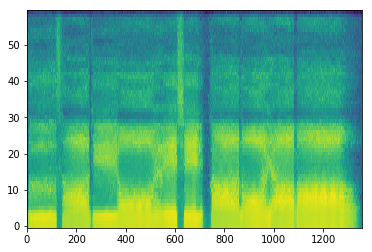

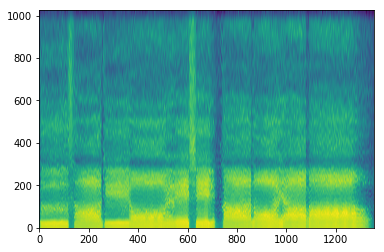

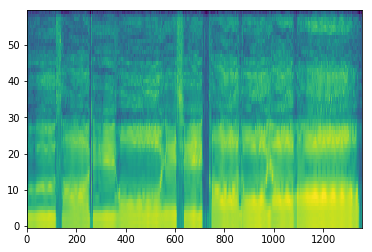

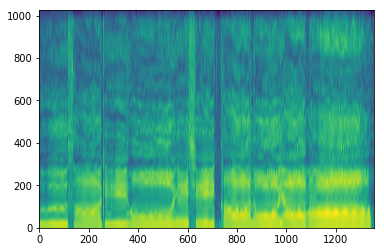

(1356,)
(1356, 1025) (1356, 60)
(1356, 1025) (1356, 4)


In [5]:
    song_name = '040_0'
    t = 'piecewise'
    epoch = 'weight_decay_1650'
    
    
    [sp_min, sp_max, ap_min, ap_max] = np.load('data/timbre_model/min_max_record.npy')
    condi = get_condition(song_name)
    #cat_input = get_ap_cat()
    #fist_input = get_first_input()
    sp, raw_sp = generate_timbre(0, sp_max, sp_min, condi, None, None)

    plt.imshow(np.log(np.transpose(sp)), aspect='auto', origin='bottom', interpolation='none')
    plt.show()

    sp1 = load_timbre('data/timbre_model/test/sp/nitech_jp_song070_f001_'+song_name+'_sp.npy', 0, sp_max, sp_min)

    plt.imshow(np.log(np.transpose(sp1)), aspect='auto', origin='bottom', interpolation='none')
    plt.show()
####################################################################################################
#     ap, raw_ap = generate_timbre(1, ap_max, ap_min, condi, raw_sp, None)
    
#     plt.imshow(np.log(np.transpose(ap)), aspect='auto', origin='bottom', interpolation='none')
#     plt.show()
    
#     ap1 = load_timbre('data/timbre_model/test/ap/nitech_jp_song070_f001_'+song_name+'_ap.npy', 1, ap_max, ap_min)
    
#     plt.imshow(np.log(np.transpose(ap1)), aspect='auto', origin='bottom', interpolation='none')
#     plt.show()

#########################################################################################################
    # vuv_cat = get_vuv_cat()
#     gen_cat = torch.cat((raw_ap, raw_sp), 0)
    
#     vuv = generate_vuv(condi, gen_cat)
#     plt.plot(vuv)
#     plt.show()
    
#     vuv1 = np.load('data/timbre_model/test/vuv/nitech_jp_song070_f001_'+song_name+'_vuv.npy')
#     plt.plot(vuv1)
#     plt.show()

    path = 'data/cut_raw/nitech_jp_song070_f001_'+song_name+'.raw'
    _f0, _sp, _ap = process_wav(path)
    # 合成原始语音
    synthesized = pw.synthesize(_f0, sp, _ap, 32000, pw.default_frame_period)
    # 1.输出原始语音
    sf.write('./data/gen_wav/'+epoch+'epoch_'+t+'_'+song_name+'.wav', synthesized, 32000)